In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/doubanmovieshortcomments/DMSC.csv


In [4]:
import csv
import jieba
ds_comments = []
with open("/kaggle/input/doubanmovieshortcomments/DMSC.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        vote = int(row['Star'])
        if vote in [1,2,4,5]:
            words = jieba.lcut(row['Comment'])   
            ds_comments.append((words, 1 if vote > 3 else 0))  # 1 for positive, 0 for negative

len(ds_comments)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.619 seconds.
Prefix dict has been built successfully.


1650497

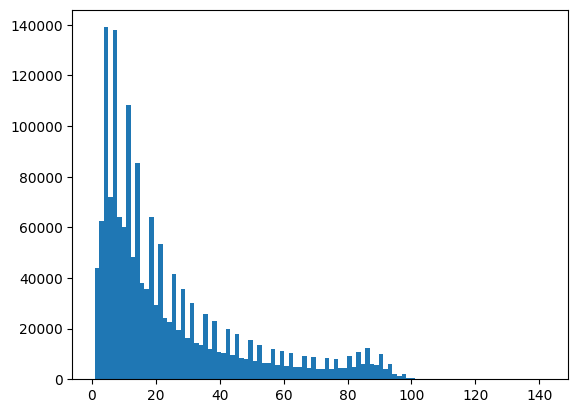

In [5]:
import matplotlib.pyplot as plt

comments_len = [len(c) for c,v in ds_comments]
plt.hist(comments_len, bins=100)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

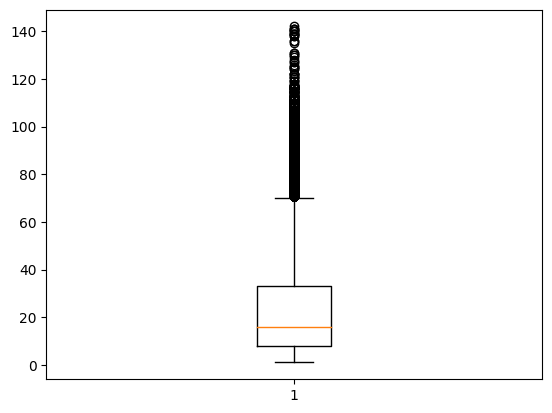

In [6]:
plt.boxplot(comments_len)
plt.show

In [7]:
ds_comments = [c for c in ds_comments if len(c[0]) in range(10,150)]

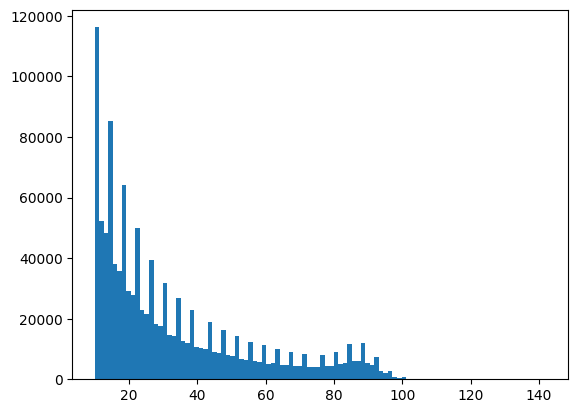

In [8]:
comments_len = [len(c) for c,v in ds_comments]
plt.hist(comments_len, bins=100)
plt.show()

In [9]:
import pickle

with open('/kaggle/working/comments_jieba.pkl', 'wb') as f:
    pickle.dump(ds_comments, f)

In [10]:
#提取全部评论，存在单独txt，文件用于训练sentencepiece分词
comments_txt = open("/kaggle/working/comments.txt","w",encoding="utf-8")
with open("/kaggle/input/doubanmovieshortcomments/DMSC.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        comments_txt.write(row['Comment']+"\n")

In [11]:
import sentencepiece as spm
spm.SentencePieceTrainer.Train(input='/kaggle/working/comments.txt', 
                               model_prefix='comments_mod',
                               vocab_size=40000) # Train the model

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/working/comments.txt
  input_format: 
  model_prefix: comments_mod
  model_type: UNIGRAM
  vocab_size: 40000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differenti

In [12]:
sp = spm.SentencePieceProcessor(model_file='comments_mod.model')

In [13]:
ds_comments = []
with open("/kaggle/input/doubanmovieshortcomments/DMSC.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        vote = int(row['Star'])
        if vote in [1,2,4,5]:
            words = sp.EncodeAsPieces(row['Comment'])   
            ds_comments.append((words, 1 if vote > 3 else 0))

In [14]:
ds_comments = [c for c in ds_comments if len(c[0]) in range(10,150)]
with open('/kaggle/working/comments_sp.pkl', 'wb') as f:
    pickle.dump(ds_comments, f)

In [15]:
len(ds_comments)

935322

In [16]:
#文本->索引 函数 ，文档格式 [(['a','ab','bc'....],0),(['qw','gh','as'....],1)....]
def build_from_doc(doc):
    vocab = set()
    for line in doc:
        vocab.update(line[0])
    vocab =  ['PADDING','UNK'] + list(vocab)  # PAD: padding, UNK: unknown
    w2idx = {word: idx for idx, word in enumerate(vocab)}
    return w2idx

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

class Comment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, input_ids):
        embeded = self.embedding(input_ids)
        output, (hidden, _) = self.rnn(embeded)
        out = self.fc(output[:,-1])
        return out

In [18]:
#加载训练语料
with open('/kaggle/working/comments_jieba.pkl','rb') as f:
        comments_data_jieba = pickle.load(f)
with open('/kaggle/working/comments_sp.pkl','rb') as f:
        comments_data_sp = pickle.load(f)

In [19]:
#转化成词典表
vocab_jieba = build_from_doc(comments_data_jieba)
vocab_sp = build_from_doc(comments_data_sp)


In [20]:
print(vocab_jieba.get('PADDING'),vocab_jieba.get('UNK'))
print(vocab_sp.get('PADDING'),vocab_sp.get('UNK'))

0 1
0 1


In [21]:
#DataLoader回调函数，分词转化为词向量，以及对齐batch元素长度
def convert_data_jieba(batch_data):
    comments, votes = [],[]
    for c,v in batch_data:
        comments.append(torch.tensor([vocab_jieba.get(word, vocab_jieba['UNK']) for word in c]))
        votes.append(v)
    commt = pad_sequence(comments, batch_first=True, padding_value=vocab_jieba['PADDING'])  # 填充为相同长度
    labels = torch.tensor(votes)
    return commt, labels

def convert_data_sp(batch_data):
    comments, votes = [],[]
    for c,v in batch_data:
        comments.append(torch.tensor([vocab_sp.get(word, vocab_sp['UNK']) for word in c]))
        votes.append(v)
    commt = pad_sequence(comments, batch_first=True, padding_value=vocab_sp['PADDING'])  # 填充为相同长度
    labels = torch.tensor(votes)
    return commt, labels
        

In [22]:
print(len(comments_data_jieba), len(comments_data_sp))
print(0.8*len(comments_data_jieba), len(comments_data_jieba)-0.8*len(comments_data_jieba))
print(0.8*len(comments_data_sp), len(comments_data_sp)-0.8*len(comments_data_sp))

1130997 935322
904797.6000000001 226199.3999999999
748257.6000000001 187064.3999999999


In [23]:
# 通过Dataset构建DataLoader,0.8训练，0.2验证
dataloader_jieba_train = DataLoader(comments_data_jieba[:904797], batch_size=32, shuffle=True, 
                        collate_fn=convert_data_jieba)
dataloader_jieba_test = DataLoader(comments_data_jieba[904797:-1], batch_size=32, shuffle=True, 
                        collate_fn=convert_data_jieba)

dataloader_sp_train = DataLoader(comments_data_sp[:748257], batch_size=32, shuffle=True, 
                        collate_fn=convert_data_sp)
dataloader_sp_test = DataLoader(comments_data_sp[748257:-1], batch_size=32, shuffle=True, 
                        collate_fn=convert_data_sp)

In [28]:
def train(vocab, train_data, save_path):
    model = Comment_Classifier(len(vocab), 100, 128, 2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    EPOCHS = 10
    LR = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(EPOCHS):
        for i,(c,v) in enumerate(train_data):
            c = c.to(device)
            v = v.to(device)
            
            out = model(c)
            loss = criterion(out, v)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 10000 == 0:
                print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_data)}], Loss: {loss.item():.4f}')
    model.eval()
    print(f'Loss: {loss.item():.4f}')
    # 保存模型
    torch.save(model.state_dict(), save_path+'_comments_classifier.pth')
    # 模型词典
    torch.save(vocab, save_path+'_comments_vocab.pth')

In [27]:
train(vocab_jieba, dataloader_jieba_train, '/kaggle/working/jieba')

Epoch [1/10], Step [10000/28275], Loss: 0.3463
Epoch [1/10], Step [20000/28275], Loss: 0.2072
Epoch [2/10], Step [10000/28275], Loss: 0.3425
Epoch [2/10], Step [20000/28275], Loss: 0.1203
Epoch [3/10], Step [10000/28275], Loss: 0.2536
Epoch [3/10], Step [20000/28275], Loss: 0.2304
Epoch [4/10], Step [10000/28275], Loss: 0.1271
Epoch [4/10], Step [20000/28275], Loss: 0.0661
Epoch [5/10], Step [10000/28275], Loss: 0.1556
Epoch [5/10], Step [20000/28275], Loss: 0.1233
Epoch [6/10], Step [10000/28275], Loss: 0.4149
Epoch [6/10], Step [20000/28275], Loss: 0.2176
Epoch [7/10], Step [10000/28275], Loss: 0.1194
Epoch [7/10], Step [20000/28275], Loss: 0.2066
Epoch [8/10], Step [10000/28275], Loss: 0.1409
Epoch [8/10], Step [20000/28275], Loss: 0.0387
Epoch [9/10], Step [10000/28275], Loss: 0.0557
Epoch [9/10], Step [20000/28275], Loss: 0.0801
Epoch [10/10], Step [10000/28275], Loss: 0.0055
Epoch [10/10], Step [20000/28275], Loss: 0.0262


In [29]:
train(vocab_sp, dataloader_sp_train, '/kaggle/working/sp')

Epoch [1/10], Step [10000/23384], Loss: 0.5963
Epoch [1/10], Step [20000/23384], Loss: 0.3930
Epoch [2/10], Step [10000/23384], Loss: 0.1314
Epoch [2/10], Step [20000/23384], Loss: 0.3002
Epoch [3/10], Step [10000/23384], Loss: 0.0798
Epoch [3/10], Step [20000/23384], Loss: 0.3096
Epoch [4/10], Step [10000/23384], Loss: 0.0397
Epoch [4/10], Step [20000/23384], Loss: 0.1089
Epoch [5/10], Step [10000/23384], Loss: 0.1401
Epoch [5/10], Step [20000/23384], Loss: 0.2017
Epoch [6/10], Step [10000/23384], Loss: 0.1484
Epoch [6/10], Step [20000/23384], Loss: 0.0804
Epoch [7/10], Step [10000/23384], Loss: 0.0218
Epoch [7/10], Step [20000/23384], Loss: 0.1375
Epoch [8/10], Step [10000/23384], Loss: 0.0675
Epoch [8/10], Step [20000/23384], Loss: 0.0209
Epoch [9/10], Step [10000/23384], Loss: 0.0160
Epoch [9/10], Step [20000/23384], Loss: 0.0644
Epoch [10/10], Step [10000/23384], Loss: 0.0981
Epoch [10/10], Step [20000/23384], Loss: 0.0366
Loss: 0.0008


In [33]:
def test(model_path, vocab_path, test_data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vocab = torch.load(vocab_path)
    model = Comment_Classifier(len(vocab), 100, 128, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    correct,total = 0,0
    with torch.no_grad():
        for c,v in test_data:
            c = c.to(device)
            v = v.to(device)
            out = model(c)
            _,predicted = torch.max(out,1) 
            correct += (predicted == v).sum().item()
            total += v.shape[0]
    print(f'准确率:{correct/total*100}%')

In [35]:
test('/kaggle/working/jieba_comments_classifier.pth','/kaggle/working/jieba_comments_vocab.pth',dataloader_jieba_test)

/tmp/ipykernel_31/647269676.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocab = torch.load(vocab_path)
/tmp/ipykernel_31/647269676.py:5: FutureWarning: You are using

准确率:91.35760989217458%


In [36]:
test('/kaggle/working/sp_comments_classifier.pth','/kaggle/working/sp_comments_vocab.pth',dataloader_sp_test)

/tmp/ipykernel_31/647269676.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocab = torch.load(vocab_path)
/tmp/ipykernel_31/647269676.py:5: FutureWarning: You are using

准确率:91.9027712440662%
